# Section 1: Generic vs ML Overview

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
from tabulate import tabulate

In [4]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [5]:
pydf = spark.read.parquet(path_job_node_joined_dataset)

In [6]:
gen_data = pydf.where(F.col("gpu_node") == 0)
ml_data = pydf.where(F.col("gpu_node") == 1)

In [7]:
gen_count = gen_data.select(F.col("node")).distinct().count()
ml_count = ml_data.select(F.col("node")).distinct().count()
print(gen_count, ml_count)

287 51


In [9]:
df_prom_slurm = pydf.withColumn('job_duration_seconds', F.unix_timestamp('end_date') - F.unix_timestamp('start_date'))
df_prom_slurm = get_gpu_node_col(df_prom_slurm, 'node')
df_prom_slurm = df_prom_slurm.withColumn('rack', F.regexp_extract('node', r'(r[0-9]+)n', 1))

states = df_prom_slurm.select('state').distinct().rdd.map(lambda r: r[0]).collect()
print(states)

# group by node, timestamp and aggregate by summing up the counts for each state in a new column
df_prom_slurm_job_count = df_prom_slurm.groupBy('node', 'timestamp').agg(*[F.sum(when(col('state') == state, 1).otherwise(0)).alias(state) for state in states])
df_prom_slurm_job_count = df_prom_slurm_job_count.withColumn('total_jobs_running', F.expr(' + '.join(states)))
df_prom_slurm_job_count.show(5, False)

df_prom_slurm_2 = df_prom_slurm.join(df_prom_slurm_job_count, ['node', 'timestamp'], how='left')
df_prom_slurm_2 = df_prom_slurm_2.withColumn('node_power_usage_per_job', col('node_power_usage') / col('total_jobs_running'))
df_prom_slurm_2.show(5, False)

['OUT_OF_MEMORY', 'TIMEOUT', 'FAILED', 'CANCELLED', 'NODE_FAIL', 'COMPLETED']


+------+-------------------+-------------+-------+------+---------+---------+---------+------------------+
|node  |timestamp          |OUT_OF_MEMORY|TIMEOUT|FAILED|CANCELLED|NODE_FAIL|COMPLETED|total_jobs_running|
+------+-------------------+-------------+-------+------+---------+---------+---------+------------------+
|r25n25|2022-09-09 13:41:00|0            |1      |0     |0        |0        |0        |1                 |
|r25n25|2022-09-09 15:00:00|0            |1      |0     |0        |0        |0        |1                 |
|r25n25|2022-09-09 15:14:30|0            |1      |0     |0        |0        |0        |1                 |
|r25n25|2022-09-09 15:28:00|0            |1      |0     |0        |0        |0        |1                 |
|r25n25|2022-09-09 18:00:30|0            |1      |0     |0        |0        |0        |1                 |
+------+-------------------+-------------+-------+------+---------+---------+---------+------------------+
only showing top 5 rows



+------+-------------------+---------+-----------------+-----------+----------------+---+------------------------+-----------------------+---------------------------+----------+----------+------------------------+----------------------------+-------------------------+-----------------------+-----------------+------------------------+----------------------------+---------------+-----------------------+------------------------+----------------------+-----------------------------+--------------------------+------------------+-------------------------+-------------------------+------------------+----------------+---------------------------+----------------------------+---------------------------+-------------------------------+-------------------------+-------------------------------------+--------------------------------+---------------------------------+------------------------------+--------------------------+---------------------------+--------------------------+-----------------------

In [10]:
df_prom_slurm_energy = df_prom_slurm_2.groupBy('slurm_id', 'node').agg(
    F.mean('node_power_usage_per_job').alias('mean_job_node_power_usage'),
    F.first('job_duration_seconds').alias('job_duration_seconds'),
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state')
).withColumn('job_node_energy_usage', F.col('mean_job_node_power_usage') * F.col('job_duration_seconds')).groupBy('slurm_id').agg(
    F.sum('job_node_energy_usage').alias('multinode_job_node_energy_usage'),
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state')
).groupBy('gpu_node', 'state').agg(
    F.sum('multinode_job_node_energy_usage').alias('job_type_node_energy_usage_total')
)
df_prom_slurm_energy.orderBy('gpu_node', 'state').show(20, False)
df_prom_slurm_energy_sum = df_prom_slurm_energy.groupBy('gpu_node').sum('job_type_node_energy_usage_total')
df_prom_slurm_energy_sum.orderBy('gpu_node').show(5, False)

total_energy = df_prom_slurm_energy_sum.select(F.sum('sum(job_type_node_energy_usage_total)')).collect()[0][0]

print(f"Percentage of energy generic: {df_prom_slurm_energy_sum.filter(F.col('gpu_node') == 0).collect()[0][1] / total_energy * 100:.2f}% \
    Percentage of energy ML: {df_prom_slurm_energy_sum.filter(F.col('gpu_node') == 1).collect()[0][1] / total_energy * 100:.2f}%")

+--------+-------------+--------------------------------+
|gpu_node|state        |job_type_node_energy_usage_total|
+--------+-------------+--------------------------------+
|0       |CANCELLED    |2.651757735987505E10            |
|0       |COMPLETED    |1.372188072146958E11            |
|0       |FAILED       |1.0629532399350313E10           |
|0       |NODE_FAIL    |7.603128584132088E9             |
|0       |OUT_OF_MEMORY|2.2527581077984495E9            |
|0       |TIMEOUT      |8.512093327438115E10            |
|1       |CANCELLED    |2.9534506993850616E10           |
|1       |COMPLETED    |8.315266117146094E10            |
|1       |FAILED       |7.945788024926845E9             |
|1       |NODE_FAIL    |4.4316968978609633E8            |
|1       |OUT_OF_MEMORY|1.7887963345175433E9            |
|1       |TIMEOUT      |4.749171268834755E10            |
+--------+-------------+--------------------------------+



+--------+-------------------------------------+
|gpu_node|sum(job_type_node_energy_usage_total)|
+--------+-------------------------------------+
|0       |2.6934273694023285E11                |
|1       |1.703566349028896E11                 |
+--------+-------------------------------------+



Percentage of energy generic: 61.26%     Percentage of energy ML: 38.74%


In [11]:
# Job Failures
df_prom_slurm_state_count = df_prom_slurm.groupBy('slurm_id').agg(F.first('gpu_node').alias('gpu_node'), F.first('state').alias('state')).groupBy('gpu_node', 'state').count()
df_prom_slurm_state_count.show(20, False)

+--------+-------------+------+
|gpu_node|state        |count |
+--------+-------------+------+
|1       |CANCELLED    |3669  |
|0       |CANCELLED    |9594  |
|0       |FAILED       |38237 |
|1       |OUT_OF_MEMORY|130   |
|1       |NODE_FAIL    |107   |
|1       |COMPLETED    |17306 |
|0       |OUT_OF_MEMORY|4497  |
|1       |FAILED       |4664  |
|1       |TIMEOUT      |1411  |
|0       |COMPLETED    |202999|
|0       |NODE_FAIL    |1427  |
|0       |TIMEOUT      |10630 |
+--------+-------------+------+



In [12]:
pltdf = pd.DataFrame([{
    "type": "Generic",
    "Rack Count": df_prom_slurm.filter(F.col("gpu_node") == 0).select(F.col("rack")).distinct().count(),
    "Node Count": df_prom_slurm.filter(F.col("gpu_node") == 0).select(F.col("node")).distinct().count(),
    "Job Energy": df_prom_slurm_energy_sum.filter(F.col("gpu_node") == 0).collect()[0][1],
    "Job Failures": df_prom_slurm_state_count.filter(F.col("gpu_node") == 0).filter(F.col("state") == "FAILED").select(F.col("count")).collect()[0][0],
    "Job Submissions": df_prom_slurm.filter(F.col("gpu_node") == 0).select(F.col("slurm_id")).distinct().count(),
    "Job Runtime": df_prom_slurm.filter(F.col("gpu_node") == 0).groupBy("slurm_id").agg(F.first("job_duration_seconds").alias("job_duration_seconds")).select(F.sum("job_duration_seconds")).collect()[0][0],
},
{
    "type": "ML",
    "Rack Count": df_prom_slurm.filter(F.col("gpu_node") == 1).select(F.col("rack")).distinct().count(),
    "Node Count": df_prom_slurm.filter(F.col("gpu_node") == 1).select(F.col("node")).distinct().count(),
    "Job Energy": df_prom_slurm_energy_sum.filter(F.col("gpu_node") == 1).collect()[0][1],
    "Job Failures": df_prom_slurm_state_count.filter(F.col("gpu_node") == 1).filter(F.col("state") == "FAILED").select(F.col("count")).collect()[0][0],
    "Job Submissions": df_prom_slurm.filter(F.col("gpu_node") == 1).select(F.col("slurm_id")).distinct().count(),
    "Job Runtime": df_prom_slurm.filter(F.col("gpu_node") == 1).groupBy("slurm_id").agg(F.first("job_duration_seconds").alias("job_duration_seconds")).select(F.sum("job_duration_seconds")).collect()[0][0],
}
])

# normalize
for col in pltdf.columns:
    if col != "type":
        pltdf[col] = pltdf[col] / pltdf[col].sum()

pltdf

,type,Rack Count,Node Count,Job Energy,Job Failures,Job Submissions,Job Runtime
0,Generic,0.52381,0.849112,0.612561,0.891285,0.907398,0.832194
1,ML,0.47619,0.150888,0.387439,0.108715,0.092602,0.167806


In [13]:
melted_df = pltdf.melt(id_vars=["type"])
melted_df["type"] = pd.Categorical(melted_df["type"], ["ML", "Generic"], ordered=True)
melted_df["variable"] = pd.Categorical(melted_df["variable"], reversed(["Rack Count", "Node Count", "Job Submissions", "Job Failures", "Job Runtime", "Job Energy"]), ordered=True)
melted_df

,type,variable,value
0,Generic,Rack Count,0.523810
1,ML,Rack Count,0.476190
2,Generic,Node Count,0.849112
3,ML,Node Count,0.150888
4,Generic,Job Energy,0.612561
5,ML,Job Energy,0.387439
6,Generic,Job Failures,0.891285
7,ML,Job Failures,0.108715
8,Generic,Job Submissions,0.907398
9,ML,Job Submissions,0.092602


In [14]:
df = pltdf.drop(columns=["Rack Count", "Node Count", "Job Failures"])

df = df[["type", "Job Submissions", "Job Runtime", "Job Energy"]]
df.iloc[:, 1:] = (df.iloc[:, 1:] * 100).round(2)
df = df.astype(str)
df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: x + "%")


latex_table = tabulate(df, headers='keys', tablefmt='latex', showindex=False)
print(latex_table)

\begin{tabular}{llll}
\hline
 type    & Job Submissions   & Job Runtime   & Job Energy   \\
\hline
 Generic & 90.74\%            & 83.22\%        & 61.26\%       \\
 ML      & 9.26\%             & 16.78\%        & 38.74\%       \\
\hline
\end{tabular}


/tmp/ipykernel_459987/3627473518.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = melted_df_2.pivot_table(index='variable', columns='type', values='value', fill_value=0)


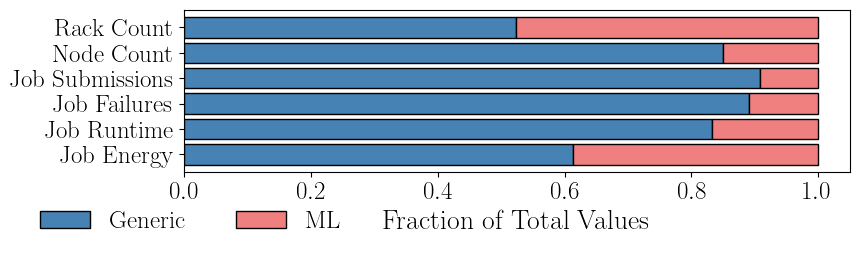

In [15]:
if "seaborn-whitegrid" in plt.style.available:
    plt.style.use("seaborn-whitegrid")
elif "seaborn-v0_8-whitegrid" in plt.style.available:
    plt.style.use('seaborn-v0_8-whitegrid')
else:
    print("Check available styles with plt.style.available")

set_one_column_figure_font(height_multiplier=0.50)

melted_df_2 = melted_df.copy()
melted_df_2['type'] = pd.Categorical(melted_df_2['type'], categories=['Generic', 'ML'], ordered=True)
pivot_df = melted_df_2.pivot_table(index='variable', columns='type', values='value', fill_value=0)

fig, ax = plt.subplots()
colors = [non_gpu_color, gpu_color]

bottom = None
for i, col in enumerate(pivot_df.columns):
    ax.barh(pivot_df.index, pivot_df[col], left=bottom, color=colors[i], edgecolor='black', label=col)
    if bottom is None:
        bottom = pivot_df[col]
    else:
        bottom += pivot_df[col]

legend = ax.legend(title='', ncol=2, loc="upper left", bbox_to_anchor=(-0.25, -0.10))
legend.get_frame().set_alpha(0)
loc='upper left'
ax.set_xlabel('Fraction of Total Values')
ax.set_ylabel('')


plt.tight_layout()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'libertine'

plt.show()


In [16]:
fig.savefig("plots/section_1/page1_gen_vs_ml.png", dpi=900, bbox_inches='tight')
fig.savefig("plots/section_1/page1_gen_vs_ml.pdf", bbox_inches='tight')